In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Preprocessing
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

In [2]:
data_descriptions = pd.read_csv('data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,LoanID,Identifier,string,A unique identifier for each loan.
1,Age,Feature,integer,The age of the borrower.
2,Income,Feature,integer,The annual income of the borrower.
3,LoanAmount,Feature,integer,The amount of money being borrowed.
4,CreditScore,Feature,integer,"The credit score of the borrower, indicating their creditworthiness."
5,MonthsEmployed,Feature,integer,The number of months the borrower has been employed.
6,NumCreditLines,Feature,integer,The number of credit lines the borrower has open.
7,InterestRate,Feature,float,The interest rate for the loan.
8,LoanTerm,Feature,integer,The term length of the loan in months.
9,DTIRatio,Feature,float,"The Debt-to-Income ratio, indicating the borrower's debt compared to their income."


In [3]:
df = pd.read_csv("data.csv")
print(df.shape)
df.head()

(255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:
# Nulls
print(df.isna().sum())

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


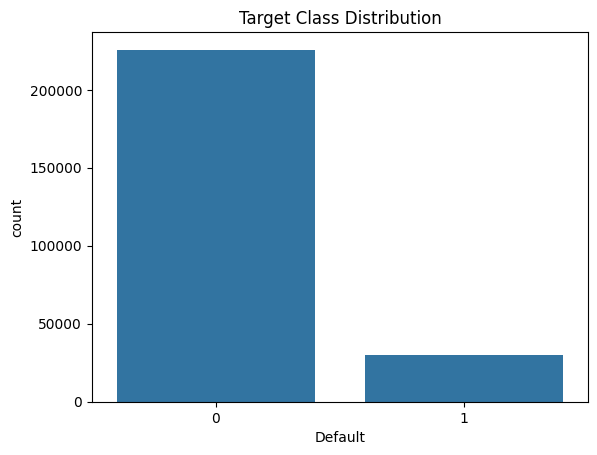

Default
0    0.883872
1    0.116128
Name: proportion, dtype: float64


In [5]:
# Target class distribution
sns.countplot(x="Default", data=df)
plt.title("Target Class Distribution")
plt.show()
print(df["Default"].value_counts(normalize=True))

In [6]:
df["AffRatio"] = df["LoanAmount"] / df["Income"]
df["TotalInterest"] = df["InterestRate"] * df["LoanTerm"]
df["Debt"] = df["DTIRatio"] * df["Income"]
df["AvgBorrowed"] = df["LoanAmount"] / df["NumCreditLines"]

In [7]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,AffRatio,TotalInterest,Debt,AvgBorrowed
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,Divorced,Yes,Yes,Other,Yes,0,0.588262,548.28,37837.36,12646.750000
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,Married,No,No,Other,Yes,0,2.467481,288.60,34293.76,124440.000000
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,Divorced,Yes,Yes,Auto,No,1,1.534154,508.08,26104.48,43062.666667
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,Married,No,No,Business,No,0,1.412638,169.68,7293.99,14933.000000
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,Divorced,No,Yes,Auto,No,0,0.447179,312.48,14919.01,2284.750000


In [8]:
categorical = df.select_dtypes(include="object").drop(columns="LoanID", errors="ignore").columns
for col in categorical:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

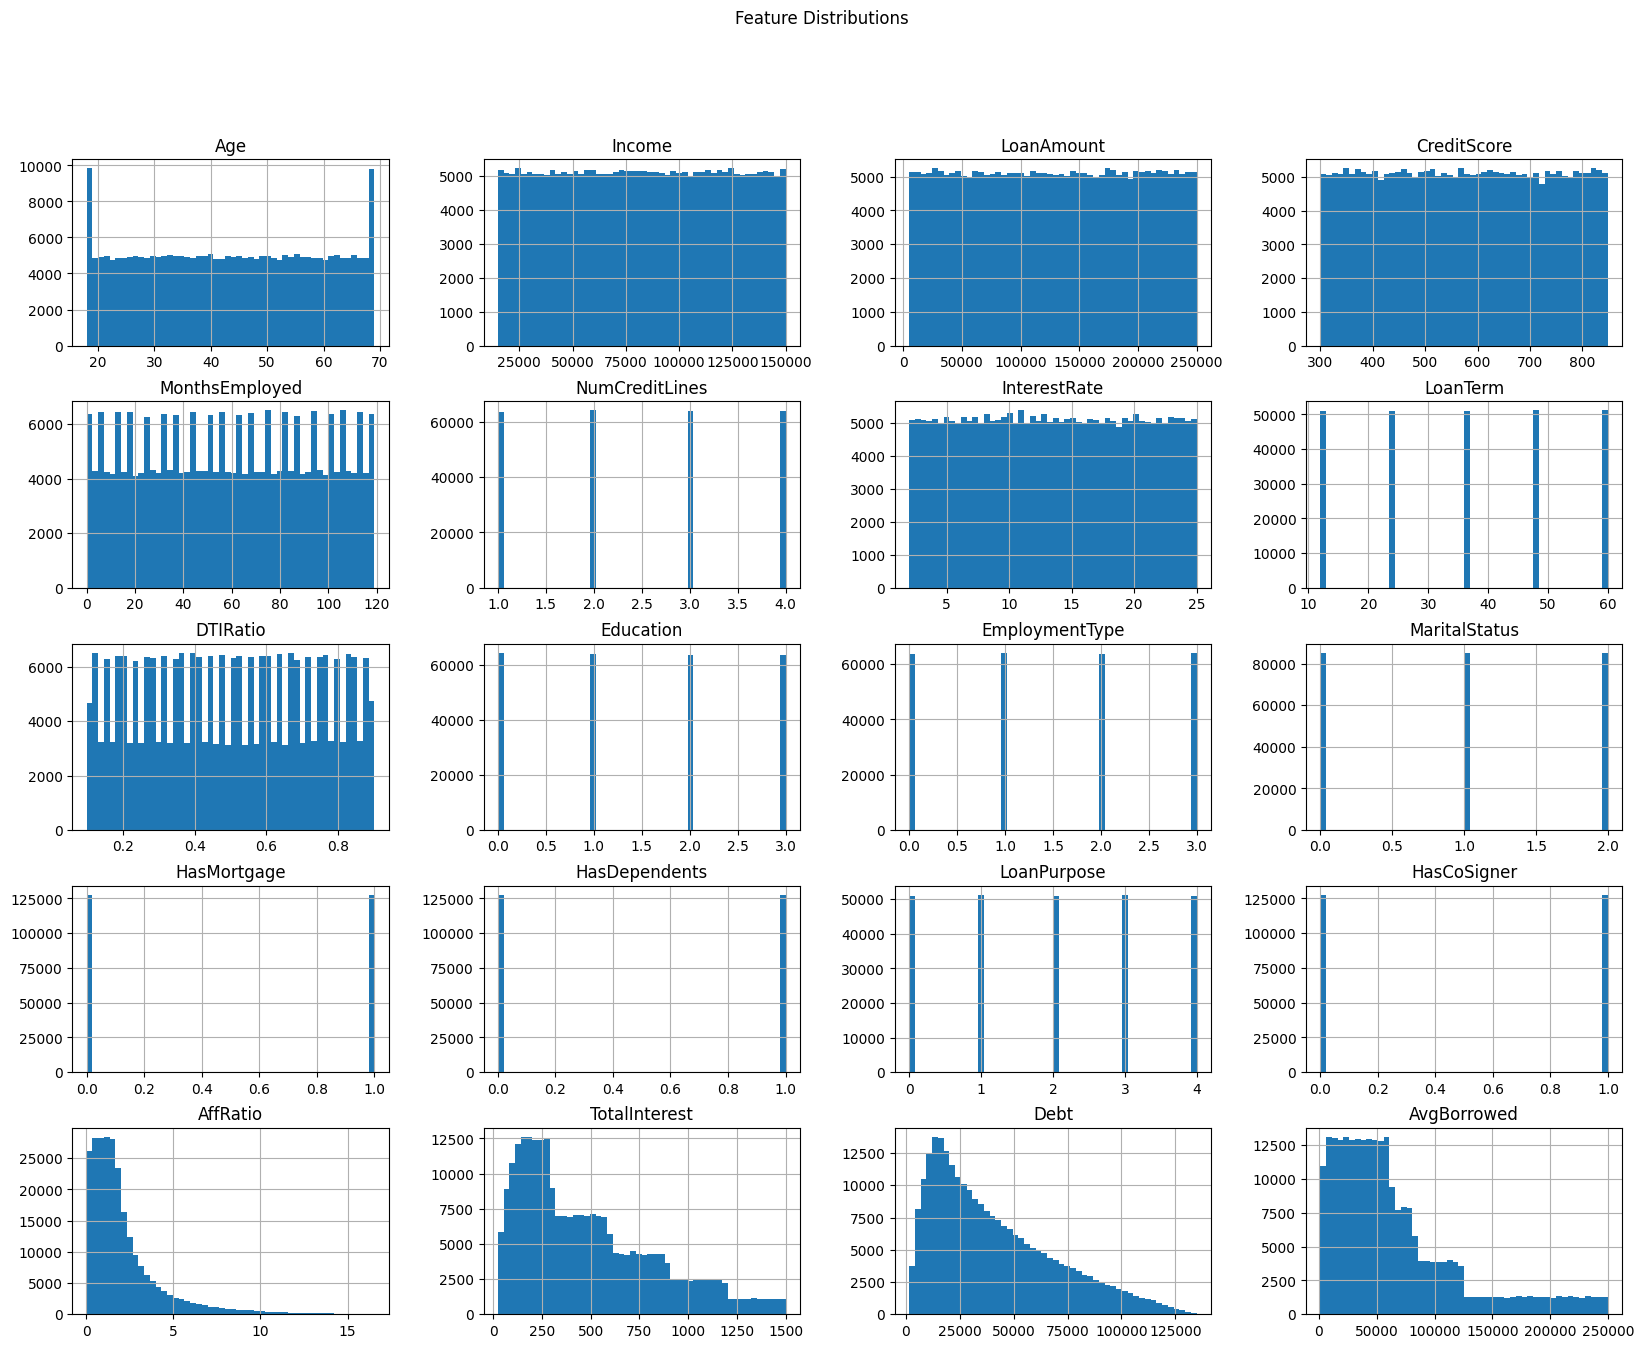

Skewness:
 AffRatio          2.333613
AvgBorrowed       1.424234
TotalInterest     0.865708
Debt              0.847150
Education         0.007009
CreditScore       0.004688
InterestRate      0.004608
EmploymentType    0.001174
Age               0.000698
MaritalStatus     0.000151
HasMortgage      -0.000055
NumCreditLines   -0.000278
LoanPurpose      -0.000303
Income           -0.000381
HasCoSigner      -0.000431
HasDependents    -0.001073
DTIRatio         -0.001499
LoanAmount       -0.001827
MonthsEmployed   -0.002142
LoanTerm         -0.002178
dtype: float64


In [9]:
features = df.drop(columns=["LoanID", "Default"])
features.hist(bins=50, figsize=(20, 15))
plt.suptitle("Feature Distributions")
plt.show()

skewness = features.skew(numeric_only=True).sort_values(ascending=False)
print("Skewness:\n", skewness)

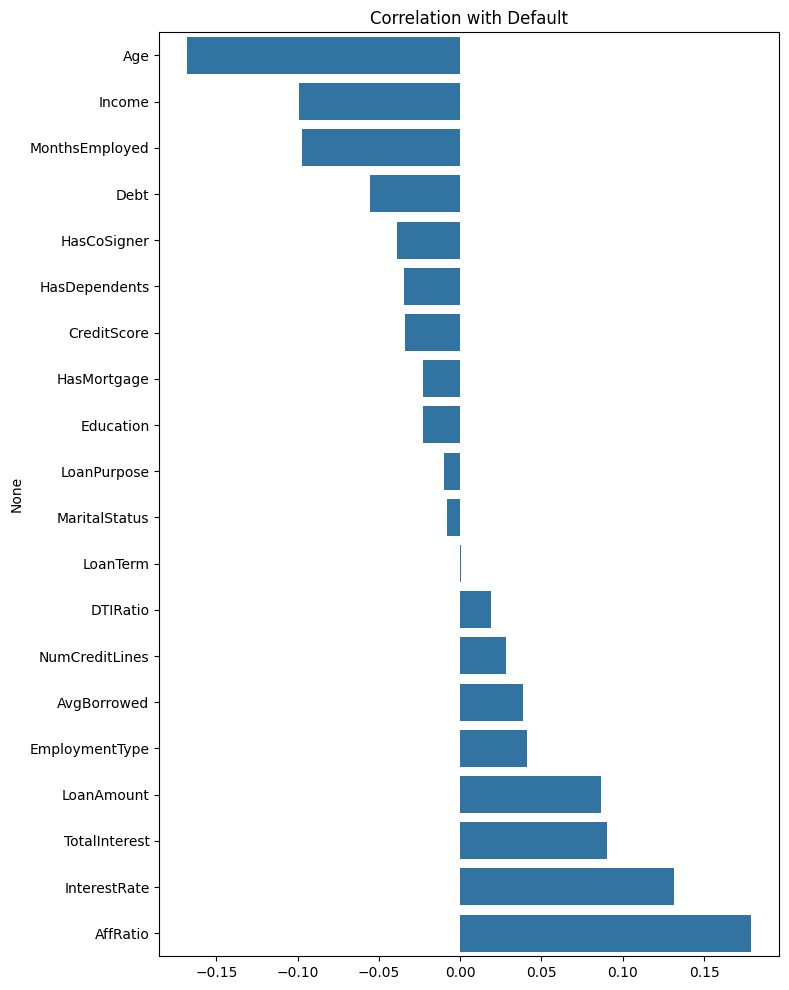

In [10]:
corrs = df.corr(numeric_only=True)["Default"].drop("Default").sort_values()
plt.figure(figsize=(8, 12))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title("Correlation with Default")
plt.show()

In [11]:
skewed = ["AffRatio", "AvgBorrowed", "TotalInterest", "Debt"]
pt = PowerTransformer(method="box-cox")
df[skewed] = pt.fit_transform(df[skewed])

In [12]:
X = df.drop(columns=["LoanID", "Default"])
y = df["Default"]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [13]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [15]:
def evaluate_model(name, model, X_val, y_val, is_nn=False):
    if is_nn:
        y_pred_proba = model.predict(X_val).flatten()
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]

    y_pred = (y_pred_proba >= 0.5).astype(int)

    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return {
        "Model": name,
        "ROC AUC": roc_auc_score(y_val, y_pred_proba),
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
    }

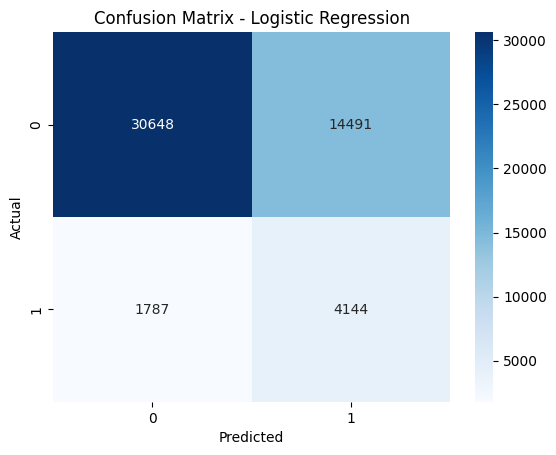

In [16]:
log_reg = LogisticRegression(
    C=1.0, penalty='l2', solver='liblinear', random_state=42, class_weight="balanced"
)
log_reg.fit(X_train_scaled, y_train)

results = []
results.append(evaluate_model("Logistic Regression", log_reg, X_val_scaled, y_val))

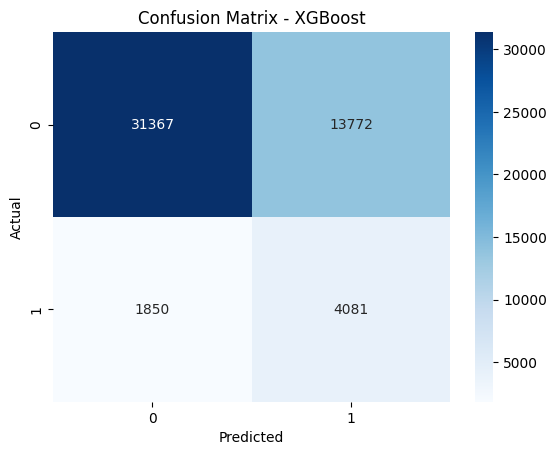

In [17]:
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=10,
)

xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

results.append(evaluate_model("XGBoost", xgb, X_val, y_val))

Epoch 1/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.6146 - val_loss: 0.5983
Epoch 2/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.5926 - val_loss: 0.5941
Epoch 3/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 0.5919 - val_loss: 0.5732
Epoch 4/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5939 - val_loss: 0.6015
Epoch 5/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.5908 - val_loss: 0.5794
Epoch 6/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.5950 - val_loss: 0.6106
Epoch 7/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5903 - val_loss: 0.5836
Epoch 8/50
6384/6384 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.5934 - val_loss: 0.5926
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


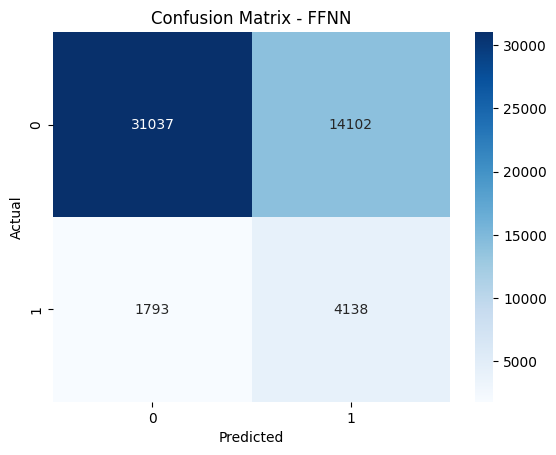

In [19]:
model_ffnn = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_ffnn.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=[])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_ffnn.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weights,
    callbacks=[early_stop],
)

results.append(evaluate_model("FFNN", model_ffnn, X_val_scaled, y_val, is_nn=True))

In [20]:
results_df = pd.DataFrame(results)
print(results_df.sort_values("ROC AUC", ascending=False))

                 Model   ROC AUC  Accuracy  Precision    Recall  F1 Score
1              XGBoost  0.758221  0.694106   0.228589  0.688080  0.343172
2                 FFNN  0.757083  0.688761   0.226864  0.697690  0.342394
0  Logistic Regression  0.754007  0.681261   0.222377  0.698702  0.337377


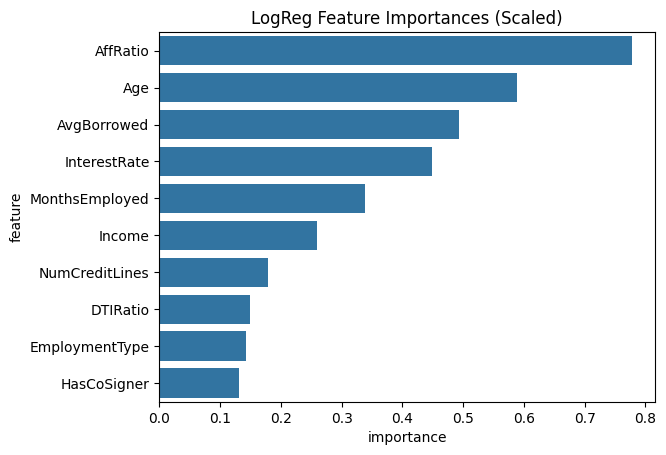

In [21]:
importances = np.abs(log_reg.coef_[0])
feat_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_df = feat_df.sort_values("importance", ascending=False)

sns.barplot(x="importance", y="feature", data=feat_df.head(10))
plt.title("LogReg Feature Importances (Scaled)")
plt.show()

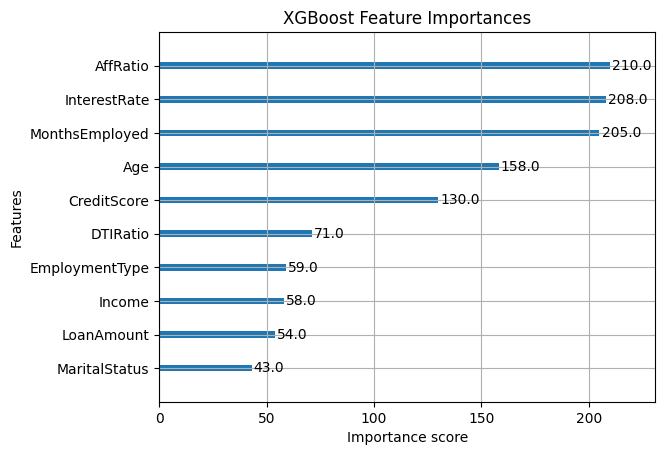

In [25]:
plot_importance(xgb, max_num_features=10)
plt.title("XGBoost Feature Importances")
plt.show()

In [26]:
import joblib
joblib.dump(log_reg, "logistic_regression_model.pkl")

['logistic_regression_model.pkl']

In [27]:
import pickle
with open("xgboost_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

In [28]:
model_ffnn.save("ffnn_model.keras")

In [29]:
joblib.dump(scaler, "standard_scaler.pkl")

['standard_scaler.pkl']

In [30]:
import json
with open("feature_names.json", "w") as f:
    json.dump(X_train.columns.tolist(), f)

In [31]:
from google.colab import files

files.download("logistic_regression_model.pkl")
files.download("xgboost_model.pkl")
files.download("ffnn_model.keras")
files.download("standard_scaler.pkl")
files.download("feature_names.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>